In [187]:
#Importing necessary libraries
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [188]:
#Loading training and test datasets
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [189]:
#Drop unnecessary columns
passangerids = test_data['PassengerId']
train_data.drop(['PassengerId', 'Name', 'Ticket'], inplace=True, axis=1)
test_data.drop(['PassengerId', 'Name', 'Ticket'], inplace=True,axis=1)

In [190]:
#Separate target from predictors
y_train = train_data['Survived']
X_train = train_data.drop(['Survived'],axis=1)

In [191]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


In [192]:
#Keep only categorical columns with low cardinality
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object" and X_train[cname].nunique() < 10]
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
X_train = X_train[categorical_cols + numerical_cols]
X_test = test_data[categorical_cols + numerical_cols]

In [193]:
#Check all possible values of categorical columns
for col in categorical_cols:
    print(X_train[col].unique(),end='\n\n')

['male' 'female']

['S' 'C' 'Q' nan]



array([[<AxesSubplot:xlabel='Pclass', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Age', ylabel='Pclass'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Parch', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Fare', ylabel='Pclass'>],
       [<AxesSubplot:xlabel='Pclass', ylabel='Age'>,
        <AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Age'>,
        <AxesSubplot:xlabel='Parch', ylabel='Age'>,
        <AxesSubplot:xlabel='Fare', ylabel='Age'>],
       [<AxesSubplot:xlabel='Pclass', ylabel='SibSp'>,
        <AxesSubplot:xlabel='Age', ylabel='SibSp'>,
        <AxesSubplot:xlabel='SibSp', ylabel='SibSp'>,
        <AxesSubplot:xlabel='Parch', ylabel='SibSp'>,
        <AxesSubplot:xlabel='Fare', ylabel='SibSp'>],
       [<AxesSubplot:xlabel='Pclass', ylabel='Parch'>,
        <AxesSubplot:xlabel='Age', ylabel='Parch'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Parch'>,
        <AxesSubplot:xlabel='Parch', 

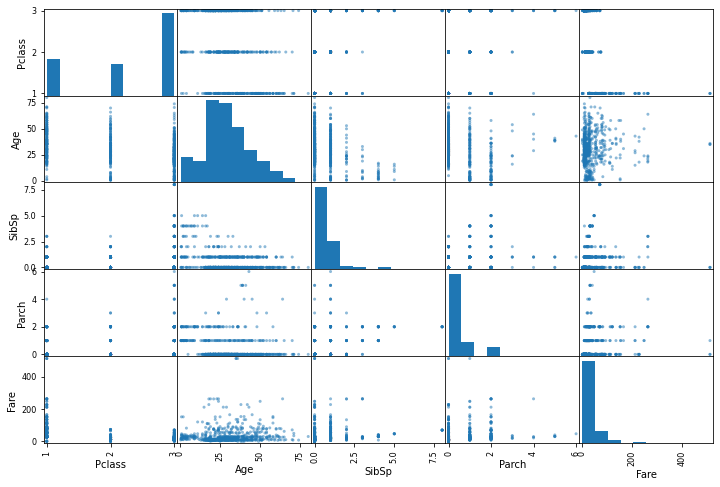

In [194]:
#Check column distributions
scatter_matrix(X_train, figsize=(12,8))

In [195]:
#Pipeline for continuous numerical columns
cont_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])

In [196]:
#Pipeline for categorical columns
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('1hotencoder', OneHotEncoder())
])

In [197]:
#Fitting and transforming our predictors using full pipeline created
full_pipeline = ColumnTransformer([
    ('cont', cont_pipeline, ['Age','Fare']),
    ('cat',cat_pipeline, categorical_cols)
])
X_train_prepared = full_pipeline.fit_transform(X_train)

In [198]:
#Creating several models to test their performances
sgd_clf = SGDClassifier(random_state=15)
xgb_clf = XGBClassifier(objective='binary:logistic',random_state=15)
log_reg = LogisticRegression(random_state=15)
forest_clf = RandomForestClassifier(random_state=15)
models = {'SGD Classifier':sgd_clf, 'XGB Classifier':xgb_clf,'Logistic Regression':log_reg, 'Random Forest Classifier':forest_clf}

for model in models:
    print(f'Average accuracy of {model}: ',cross_val_score(models[model],X_train_prepared, y_train, cv=7, scoring='accuracy').mean())
    y_train_pred = cross_val_predict(models[model], X_train_prepared, y_train, cv=7)
    print(f'F1-score of {model}: ',f1_score(y_train,y_train_pred),end='\n\n')

Average accuracy of SGD Classifier:  0.7554221737907761
F1-score of SGD Classifier:  0.6528662420382166

Average accuracy of XGB Classifier:  0.8048193194600675
F1-score of XGB Classifier:  0.7371601208459213

Average accuracy of Logistic Regression:  0.7833766872890889
F1-score of Logistic Regression:  0.7106446776611695

Average accuracy of Random Forest Classifier:  0.7800548368953881
F1-score of Random Forest Classifier:  0.7065868263473054



Two most promising models tend to be XGB Classifier and Logistic Regression. For that reason, only they will be fine-tuned and compared.

In [199]:
#Grid searching the XGB Classifier model
xgb_param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=xgb_param_grid,
    scoring = 'f1',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
xgb_grid_search.fit(X_train_prepared, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=N

In [200]:
xgb_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 180}

In [201]:
#Second step of grid searching the XGB Classifier model because learning_rate's best parameter was a boundary 
xgb_param_grid = {
    'max_depth': [4],
    'n_estimators': [160,180,200],
    'learning_rate': [0.1, 0.2, 0.3]
}
xgb_grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=xgb_param_grid,
    scoring = 'f1',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

xgb_grid_search.fit(X_train_prepared, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=N

In [202]:
xgb_grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 180}

In [203]:
#Final XGB Classifier model is ready, now it's time for Logistic Regression model
final_xgb_model = xgb_grid_search.best_estimator_

In [204]:
#Fine-tuning Logistic Regression model 
log_reg_param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    'solver':['liblinear']
}

log_reg_grid_search = GridSearchCV(estimator=log_reg, param_grid=log_reg_param_grid, scoring='f1',cv=10)
log_reg_grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=15),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1')

In [205]:
log_reg_grid_search.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [206]:
#Final Logistic Regression model is ready
final_log_reg_model = log_reg_grid_search.best_estimator_

In [207]:
xgb_y_train_pred = cross_val_predict(final_xgb_model, X_train_prepared, y_train, cv=10)
log_reg_y_train_pred = cross_val_predict(final_log_reg_model, X_train_prepared, y_train, cv=10)
print('F1-score of final XGB Classifier: ',f1_score(y_train,xgb_y_train_pred),end='\n\n')
print('F1-score of final Logistic Regression: ',f1_score(y_train,log_reg_y_train_pred))

F1-score of final XGB Classifier:  0.755690440060698

F1-score of final Logistic Regression:  0.707831325301205


It seems that XGB Classifier is better after all!

In [208]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_xgb_model.predict(X_test_prepared)

In [209]:
ans_dict = {'PassengerId': passangerids, 'Survived':final_predictions}

In [210]:
ans_df = pd.DataFrame.from_dict(ans_dict)

In [212]:
ans_df.to_csv('Titanic_XGB.csv', index=False, encoding='utf-8')